In [1]:
import pnet_loader
import util
import Pnet
import torch
import random
import seaborn as sns
import pandas as pd
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.ticker as ticker


%load_ext autoreload
%autoreload 2

In [2]:
prostate_mutations = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_cnv = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_response = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/response_paper.csv')
prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_genes = pd.read_csv('/mnt/disks/pancan/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))


prostate_cnv = prostate_cnv[prostate_genes].copy()
prostate_mutations = prostate_mutations[prostate_genes].copy()

# prostate_genes = util.select_highly_variable_genes(prostate_mutations)
# prostate_genes = prostate_genes['level_1']
prostate_mutations = prostate_mutations[list(set(prostate_mutations.columns).intersection(prostate_genes))].copy()
prostate_cnv = prostate_cnv[list(set(prostate_cnv.columns).intersection(prostate_genes))].copy()

# Regenerate input as specified in prostate_paper
prostate_mutations = (prostate_mutations > 0).astype(int)
prostate_amp = (prostate_cnv > 1).astype(int)
prostate_del = (prostate_cnv < -1).astype(int)

genetic_data = {'mut': prostate_mutations, 'amp': prostate_amp, 'del': prostate_del}

canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

In [22]:
train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(0))['indicies'])

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (581, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (581, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

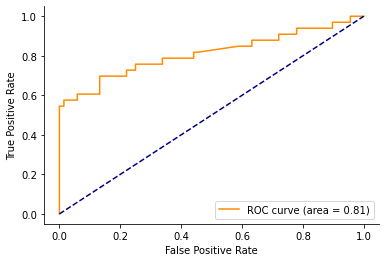

In [27]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
train_sizes = [581, 418, 300, 216, 155, 111]
for ts in train_sizes:
    for i in range(10):
        train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
        test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])

        X_train, train_inds, y_train, y_subsample = train_test_split(prostate_response.loc[train_inds].drop('response', axis=1),
                                                                     prostate_response.loc[train_inds]['response'], 
                                                                     test_size=ts,
                                                                     stratify=prostate_response.loc[train_inds]['response'],
                                                                     random_state=42)

        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                                   batch_size=64, epochs=400, early_stopping=True, train_inds=list(train_inds.index),
                                                                                   test_inds=test_inds, loss_weight=class_weights, save_path='../results/prostate_val/model',
                                                                                 loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
        plt.clf()
        Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val/ts_{}/run{}'.format(ts,i))

In [ ]:
train_sizes = [581, 418, 300, 216, 155, 111]
for ts in train_sizes:
    for i in range(10):
        train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
        test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
        
        X_train, train_inds, y_train, y_subsample = train_test_split(prostate_response.loc[train_inds].drop('response', axis=1),
                                                                     prostate_response.loc[train_inds]['response'], 
                                                                     test_size=ts,
                                                                     stratify=prostate_response.loc[train_inds]['response'],
                                                                     random_state=42)
        
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                                   batch_size=64, epochs=400, early_stopping=True, train_inds=list(train_inds.index),
                                                                                   test_inds=test_inds, loss_weight=class_weights, save_path='../results/prostate_val_fcnn/model',
                                                                                 loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes, fcnn=True)
        plt.clf()
        Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_fcnn/ts_{}/run{}'.format(ts,i))

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (581, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (581, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

In [3]:
df = pd.DataFrame(columns=['AUC', 'Training Size', 'Model'])
train_sizes = [581, 418, 300, 216, 155, 111]
for ts in train_sizes:
    for i in range(10):
        pnet_auc = torch.load('../results/prostate_val/ts_{}/run{}/AUC.pt'.format(ts, i)).item()
        fcnn_auc = torch.load('../results/prostate_val_fcnn/ts_{}/run{}/AUC.pt'.format(ts, i)).item()
        df = df.append(dict(zip(df.columns, [pnet_auc, ts, 'PNET'])), ignore_index=True)
        df = df.append(dict(zip(df.columns, [fcnn_auc, ts, 'FCNN'])), ignore_index=True)
        
for i in range(10):
    pnet_auc = torch.load('../results/prostate_val/run{}/AUC.pt'.format(i)).item()
    fcnn_auc = torch.load('../results/prostate_val_fcnn/run{}/AUC.pt'.format(i)).item()
    df = df.append(dict(zip(df.columns, [pnet_auc, 809, 'PNET'])), ignore_index=True)
    df = df.append(dict(zip(df.columns, [fcnn_auc, 809, 'FCNN'])), ignore_index=True)
df

,AUC,Training Size,Model
0,0.890571,581,PNET
1,0.886678,581,FCNN
2,0.907375,581,PNET
3,0.889816,581,FCNN
4,0.875329,581,PNET
...,...,...,...
135,0.864973,809,FCNN
136,0.863636,809,PNET
137,0.854278,809,FCNN
138,0.901070,809,PNET


In [4]:
y_mean_fcnn = df.groupby(['Model','Training Size']).mean()['AUC']['FCNN']
y_mean_pnet = df.groupby(['Model','Training Size']).mean()['AUC']['PNET']

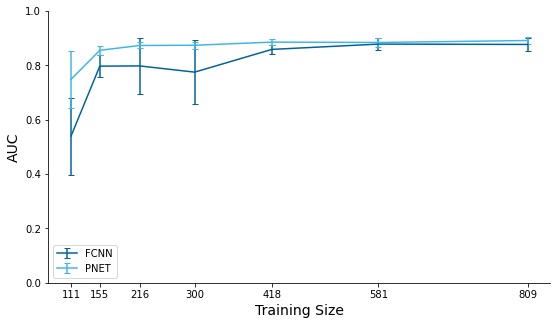

In [6]:
x = [111, 155, 216, 300, 418, 581, 809]
y_std_fcnn = df.groupby(['Model','Training Size']).std()['AUC']['FCNN']
error_fcnn = 0.5*y_std_fcnn
lower_fcnn = y_mean_fcnn - error_fcnn
upper_fcnn = y_mean_fcnn + error_fcnn

y_std_pnet = df.groupby(['Model','Training Size']).std()['AUC']['PNET']
error_pnet = 0.5*y_std_pnet
lower_pnet = y_mean_pnet - error_pnet
upper_pnet = y_mean_pnet + error_pnet

fig, ax = plt.subplots(figsize=(9,5))
ax.errorbar(x, y_mean_fcnn, error_fcnn, color='#00629B', ecolor='#00629B', capsize=3)
ax.errorbar(x, y_mean_pnet, error_pnet, color='#41B6E6', ecolor='#41B6E6', capsize=3)
ax.set_xlabel('Training Size', fontsize=14)
ax.set_ylabel('AUC', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([111, 155, 216, 300, 418, 581, 809])
plt.legend(['FCNN', 'PNET'])
plt.ylim((0,1))
plt.savefig('../figures/sample_size_reduction.pdf')
plt.show()


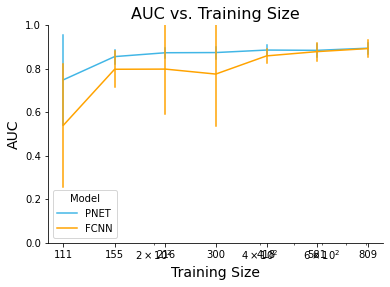

In [ ]:
sns.set_palette(['#41B6E6', '#FFA300'])

sns.lineplot(data=df, x='Training Size', y='AUC', hue='Model', ci='sd', err_style='bars')
plt.xscale('log')
plt.xticks([111, 155, 216, 300, 418, 581, 809])
plt.ylim((0,1))
ticks = plt.gca().get_xticks()

# Create a ScalarFormatter with useOffset=False to prevent scientific notation
formatter = ticker.ScalarFormatter(useOffset=False)

# Format the xticks using the desired_xticks locations
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().set_xticks([111, 155, 216, 300, 418, 581, 809])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Training Size', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.title('AUC vs. Training Size', fontsize=16)

plt.savefig('../figures/sample_size_reduction.pdf')